In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# Set paths to dataset
TRAIN = "../original_data/train/"
TEST = "../original_data/test"
LABELS = "../original_data/train.csv"
SAMPLE_SUB = "../original_data/sample_submission.csv"

In [20]:
train_data = pd.read_csv(LABELS)
print(train_data.Id.value_counts().head())

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64


In [23]:
wale_data_dict = {}
wale_data_dict["w_23a388d"] = train_data[train_data.Id == "w_23a388d"].Image.values.tolist()
wale_data_dict["w_9b5109b"] = train_data[train_data.Id == "w_9b5109b"].Image.values.tolist()
wale_data_dict["w_9c506f6"] = train_data[train_data.Id == "w_9c506f6"].Image.values.tolist()
print(wale_data_dict)

{'w_23a388d': ['02bdec750.jpg', '02f250971.jpg', '03b6593e9.jpg', '043b78dc6.jpg', '09611f0c5.jpg', '0992af029.jpg', '0ec70b0df.jpg', '18f9ce2f9.jpg', '1cb8f292a.jpg', '2ac19e867.jpg', '2ae61890a.jpg', '300cf57a9.jpg', '303938df6.jpg', '358b56609.jpg', '382323730.jpg', '3b3483ba9.jpg', '3d5c45078.jpg', '3e53c9584.jpg', '3e8b8d8d9.jpg', '47071b59c.jpg', '4b2678972.jpg', '4f987e4b7.jpg', '51ae55704.jpg', '5a1ebb56b.jpg', '5af6fa8c1.jpg', '5f420b231.jpg', '5ff37ee82.jpg', '69823499d.jpg', '6c6d5d7a4.jpg', '792a67050.jpg', '7cd8b360c.jpg', '7dda85fa3.jpg', '7e82f92ee.jpg', '7fcb6ab12.jpg', '87ec4811e.jpg', '89b00d9a7.jpg', '8c18f5ef4.jpg', '8df98d110.jpg', '8e6d570e4.jpg', '8e7ab5a22.jpg', '919d58179.jpg', '972893a51.jpg', '9e658afa0.jpg', '9e924e18d.jpg', 'a1270b8cc.jpg', 'a18c6d91a.jpg', 'a60e47c55.jpg', 'a7ddfe7d9.jpg', 'a97caed52.jpg', 'ad70af04e.jpg', 'b00a03bbd.jpg', 'b1e325bec.jpg', 'b7fb1af05.jpg', 'bb55e13fa.jpg', 'bf312b0c2.jpg', 'bf84bad36.jpg', 'c45e0efa6.jpg', 'c4e291ada.jpg',

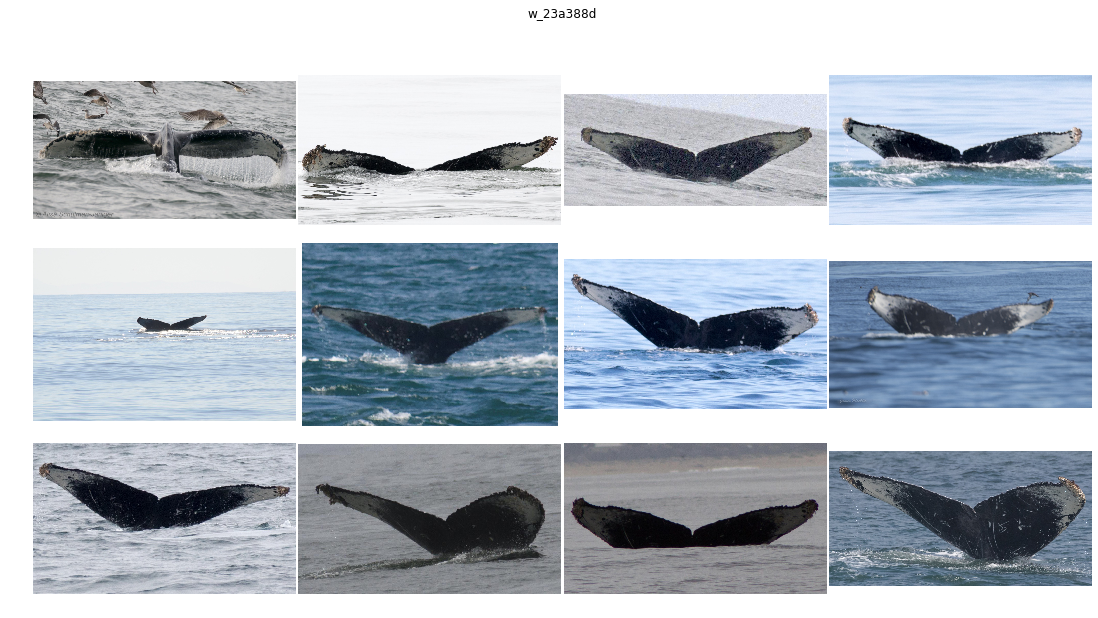

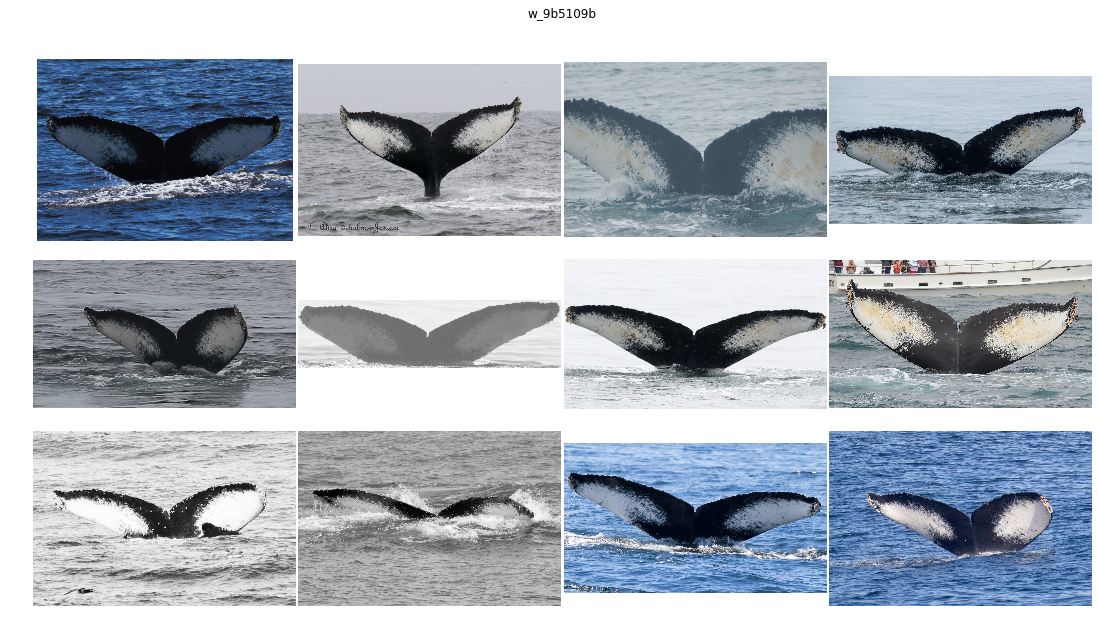

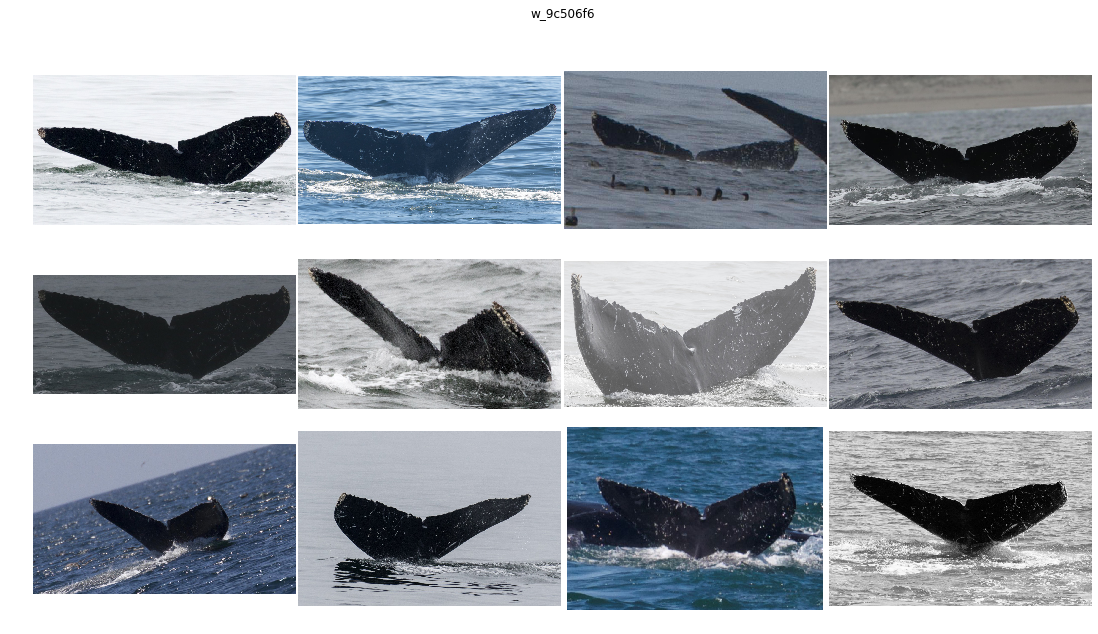

In [24]:
for wale_name in wale_data_dict:
    F = plt.figure(figsize=(15, 9))
    G = plt.GridSpec(3, 4, left=.01, right=.99, bottom=0.05, top=0.9, wspace=.01, hspace=0.01, figure=F)
    for i in range(12):
        im = plt.imread(TRAIN + wale_data_dict[wale_name][i])
        ax = plt.subplot(G[i])
        ax.imshow(im)
        ax.set_axis_off()
        ax.set_aspect('equal')
    plt.suptitle(wale_name)

In [63]:
from skimage.transform import warp, AffineTransform, ProjectiveTransform
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity, adjust_gamma, adjust_log, adjust_sigmoid
from skimage.filters import gaussian
from skimage.util import random_noise
import random
import numpy as np

In [66]:
# utility to generate random float values in desired range
def randRange(a, b):
    return np.random.rand() * (b-a) + a

In [44]:
# wrapper of Affine transformation with random scale, rotation, shear and translation parameter
def randomAffine(im):
    tform = AffineTransform(scale=(randRange(0.75, 1.3), randRange(0.75, 1.3)),
                            rotation=randRange(-0.25, 0.25),
                            shear=randRange(-0.2, 0.2),
                            translation=(randRange(-im.shape[0]//10, im.shape[0]//10),
                                         randRange(-im.shape[1]//10, im.shape[1]//10)))
    return warp(im, tform.inverse, mode='reflect')

In [68]:
# wrapper of Projective (or perspective) transform, from 4 random points selected from 
# 4 corners of the image within a defined region
def randomPerspective(im):
    region = 1/4
    A = np.array([[0, 0], [0, im.shape[0]], [im.shape[1], im.shape[0]], [im.shape[1], 0]])
    B = np.array([[int(randRange(0, im.shape[1] * region)), int(randRange(0, im.shape[0] * region))], 
                  [int(randRange(0, im.shape[1] * region)), int(randRange(im.shape[0] * (1-region), im.shape[0]))], 
                  [int(randRange(im.shape[1] * (1-region), im.shape[1])), int(randRange(im.shape[0] * (1-region), im.shape[0]))], 
                  [int(randRange(im.shape[1] * (1-region), im.shape[1])), int(randRange(0, im.shape[0] * region))], 
                 ])
    pt = ProjectiveTransform()
    pt.estimate(A, B)
    return warp(im, pt, output_shape=im.shape[:2])

In [69]:
# cropping the image in the center from a random margin from the borders
def randomCrop(im):
    margin = 1/10
    start = [int(randRange(0, im.shape[0] * margin)), int(randRange(0, im.shape[1] * margin))]
    end = [int(randRange(im.shape[0] * (1-margin), im.shape[0])), 
           int(randRange(im.shape[1] * (1-margin), im.shape[1]))]
    return im[start[0]:end[0], start[1]:end[1]]

In [70]:
# Rescales the intensity of the image to random interval of image intensity distribution
def randomIntensity(im):
    return rescale_intensity(im, 
                             in_range=tuple(np.percentile(im, (randRange(0, 10), randRange(90, 100)))),
                             out_range= tuple(np.percentile(im, (randRange(0, 10), randRange(90,100)))))

In [71]:
# gamma filter for contrast adjustment with random gamma value
def randomGamma(im):
    return adjust_gamma(im, gamma=randRange(0.5, 1.5))

In [72]:
# gaussian filter for bluring the image with random variance
def randomGaussian(im):
    return gaussian(im, sigma=randRange(0, 5))

In [96]:
# randomly selects an exposure filter from histogram equalizers, contrast adjustments and
# intensity rescaler and applies it on the input image
def randomFilter(im):
    Filters = [equalize_adapthist, equalize_hist, adjust_log, adjust_sigmoid, randomGamma, randomGaussian, randomIntensity]
    filt = random.choice(Filters)
    return filt(im)

In [74]:
# random gaussian noise with random variance
def randomNoise(im):
    var = randRange(0.001, 0.01)
    return random_noise(im, var=var)

In [98]:
# Image augmentation by doing a series of transformations on the image
def augment(im, Steps=[randomAffine, randomPerspective, randomFilter, randomNoise, randomCrop]):
    for step in Steps:
        im = step(im)
    return im

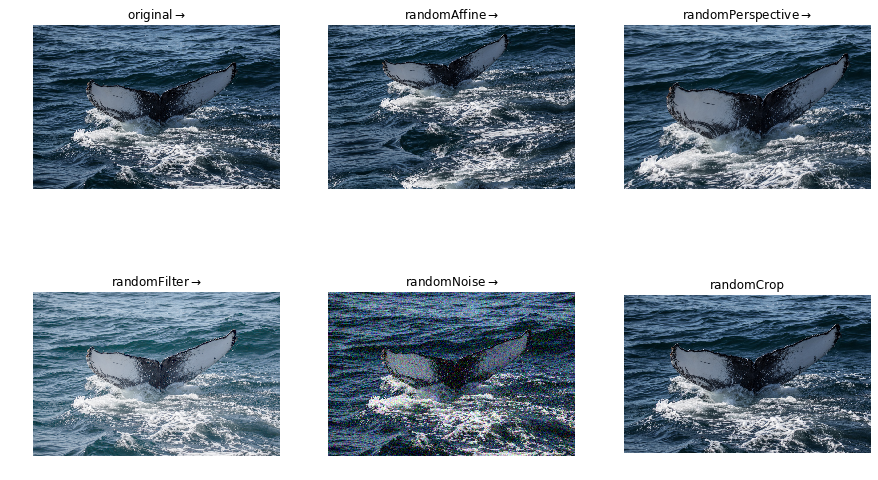

In [84]:
# Let's see an example of all the transformation, step-by-step
orig = plt.imread(TRAIN + train_data.Image[0])
F = plt.figure(figsize=(15, 9))
G = plt.GridSpec(2, 3, figure=F)
ax = plt.subplot(G[0])
ax.imshow(orig)
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('original' + r'$\rightarrow$')
for i, step in enumerate([randomAffine, randomPerspective, randomFilter, randomNoise, randomCrop]):
    ax = plt.subplot(G[i+1])
    im = step(orig)
    ax.imshow(im)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_title(step.__name__ + (r'$\rightarrow$' if i < 4 else ''))

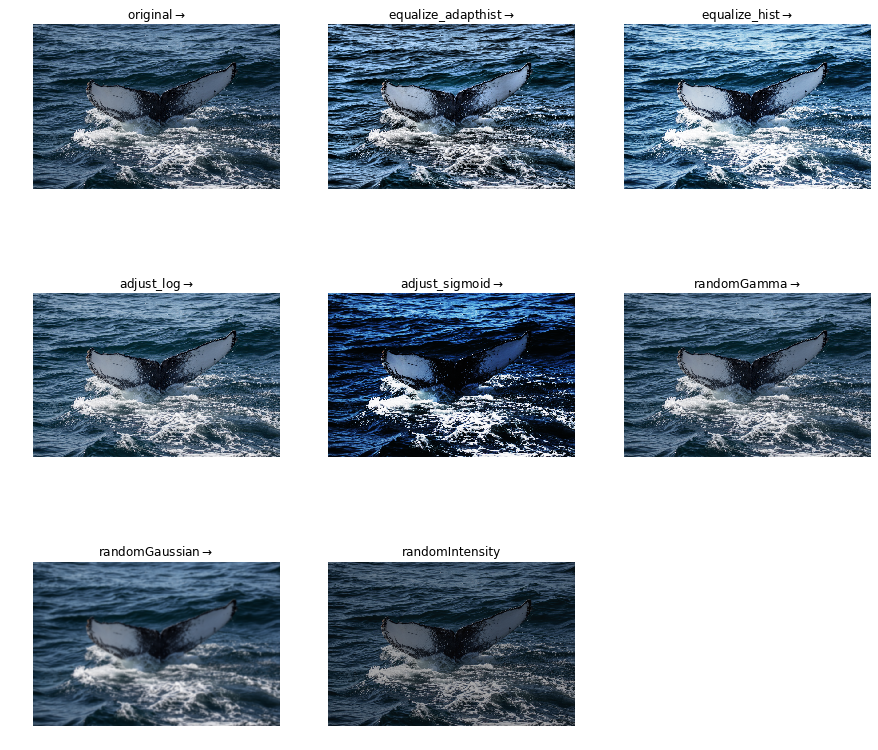

In [92]:
# Also, let's see an example through all the filter transforms
orig = plt.imread(TRAIN + train_data.Image[0])
F = plt.figure(figsize=(15, 14))
G = plt.GridSpec(3, 3, figure=F)
ax = plt.subplot(G[0])
ax.imshow(orig)
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('original' + r'$\rightarrow$')
for i, filt in enumerate([equalize_adapthist, equalize_hist, adjust_log, adjust_sigmoid, randomGamma, randomGaussian, randomIntensity]):
    ax = plt.subplot(G[i+1])
    im = filt(orig)
    ax.imshow(im)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_title(filt.__name__ + (r'$\rightarrow$' if i < 6 else ''))

In [105]:
im = plt.imread(TRAIN + train_data.Image[0])
Aug_im = [augment(im) for i in range(11)]

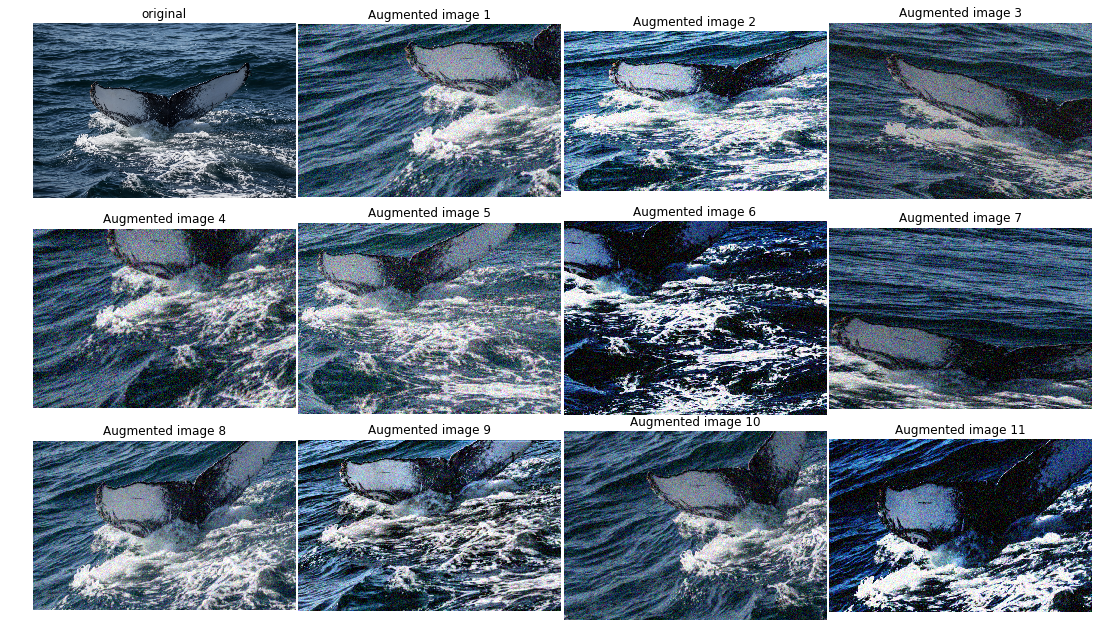

In [107]:
F = plt.figure(figsize=(15,10))
G = plt.GridSpec(3, 4, left=.01, right=.99, bottom=0.05, top=0.9, wspace=.01, hspace=0.05, figure=F)
ax = plt.subplot(G[0])
ax.imshow(im)
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('original')
for i in range(1, 12):
    ax = plt.subplot(G[i])
    ax.imshow(Aug_im[i-1])
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_title(f'Augmented image {i}')